# Laboratory 2: Computer Vision

## SETUP

In [1]:
import comet_ml
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())
COMET_API_KEY = os.getenv("COMET_API_KEY")

In [2]:
import tensorflow as tf
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import mitdeeplearning as mdl

In [3]:
assert COMET_API_KEY != "", "Please insert your Comet API Key"

## 2.1 Datasets

In [4]:
# load data
path_to_training_data = tf.keras.utils.get_file(
    "train_face.h5", "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
)

loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /Users/vamsi_mbmax/.keras/datasets/train_face.h5
Loading data into memory...


In [5]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

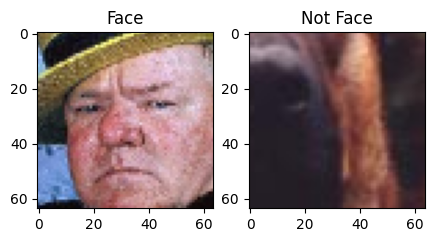

In [6]:
# examine the dataset
face_images = images[np.where(labels == 1)[0]]
not_face_images = images[np.where(labels == 0)[0]]

idx_face = 23  # @param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9  # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

## 2.2

In [7]:
### Define the CNN model ###

n_filters = 12  # base number of convolutional filters

"""Function to define a standard CNN model"""


def make_standard_classifier(n_outputs=1):
    Conv2D = functools.partial(
        tf.keras.layers.Conv2D, padding="same", activation="relu"
    )
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation="relu")

    model = tf.keras.Sequential(
        [
            Conv2D(filters=1 * n_filters, kernel_size=5, strides=2),
            BatchNormalization(),
            Conv2D(filters=2 * n_filters, kernel_size=5, strides=2),
            BatchNormalization(),
            Conv2D(filters=4 * n_filters, kernel_size=3, strides=2),
            BatchNormalization(),
            Conv2D(filters=6 * n_filters, kernel_size=3, strides=2),
            BatchNormalization(),
            Flatten(),
            Dense(512),
            Dense(n_outputs, activation=None),
        ]
    )
    return model


standard_classifier = make_standard_classifier()

In [8]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if "experiment" in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

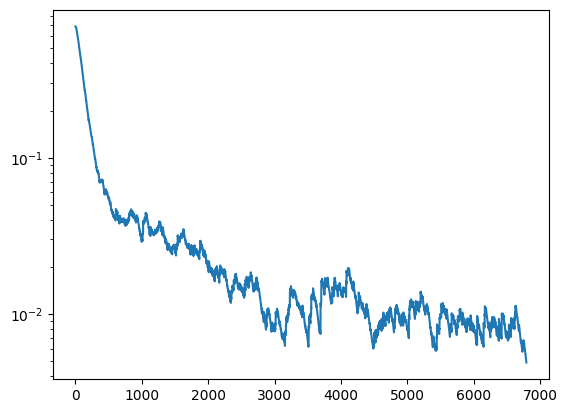

100%|██████████| 3434/3434 [00:52<00:00, 65.22it/s]


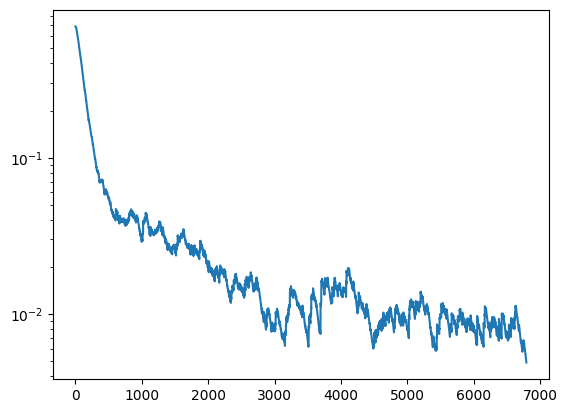

In [9]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
    batch_size=32,
    num_epochs=2,  # keep small to run faster
    learning_rate=5e-4,
)

experiment = create_experiment("6S191_Lab2_Part2_CNN", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"])  # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)  # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale="semilogy")
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()  # clear if it exists


@tf.function
def standard_train_step(x, y):
    with tf.GradientTape() as tape:
        # feed the images into the model
        logits = standard_classifier(x)
        # Compute the loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

    # Backpropagation
    grads = tape.gradient(loss, standard_classifier.trainable_variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
    return loss


# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
    for idx in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params["batch_size"])
        loss = standard_train_step(x, y)

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())

        experiment.log_metric("loss", loss.numpy().mean(), step=step)
        step += 1

### Evaluate performance of the standard CNN

In [10]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print(
    "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(
        acc_standard.numpy()
    )
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9966


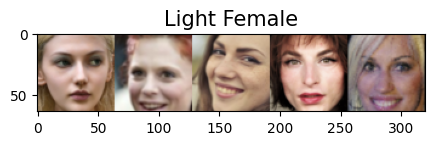

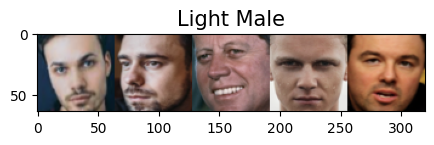

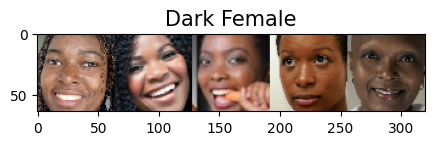

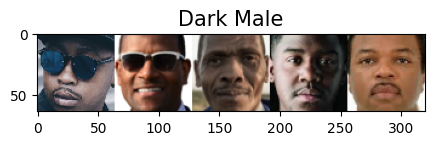

In [11]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces, keys):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.hstack(group))
    plt.title(key, fontsize=15)

Text(0.5, 1.0, 'Standard classifier predictions')

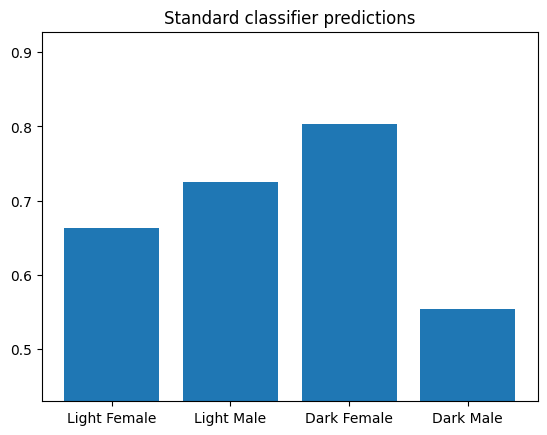

In [12]:
### Evaluate the standard CNN on the test data ###

standard_classifier_logits = [
    standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces
]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - yy.ptp() / 2.0), yy.max() + yy.ptp() / 2.0)
plt.title("Standard classifier predictions")

## 2.3 Mitigating algorithmic bias